In [ ]:
!pip install --upgrade numpy pandas matplotlib seaborn tensorflow pydot

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
import seaborn as sns

# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

In [ ]:
train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
train_df = train_df.reindex(np.random.permutation(train_df.index))

test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")

## Represent data

The following code cell creates preprocessing layers outputting three features:

* `latitude` X `longitude` (a feature cross)
* `median_income`
* `population`

This code cell specifies the features that you'll ultimately train the model on and how each of those features will be represented. The transformations (collected in `prepocessing_layers`) don't actually get applied until you pass a DataFrame to it, which will happen when we train the model.

We'll use `preprocessing_layers` for both our linear regression model and our neural network model.

(The [`keras.FeatureSpace`](https://keras.io/examples/structured_data/structured_data_classification_with_feature_space) utility offers an alternative to building individual Keras preprocessing layers -- give it a try, if you're feeling adventurous!)

In [ ]:
# Keras Input tensors of float values.
inputs = {
    'latitude':
        tf.keras.layers.Input(
            shape=(1,),
            dtype=tf.float32,
            name='latitude'),
    'longitude':
        tf.keras.layers.Input(
            shape=(1,),
            dtype=tf.float32,
            name='longitude'),
    'median_income':
        tf.keras.layers.Input(
            shape=(1,),
            dtype=tf.float32,
            name='median_income'),
    'population':
        tf.keras.layers.Input(
            shape=(1,),
            dtype=tf.float32,
            name='population')
}

# Normalization Layers

This layer will shift and scale inputs into a distribution centered around 0 with standard deviation 1. It accomplishes this by precomputing the mean and variance of the data, and calling `(input - mean) / sqrt(var)` at runtime.

The mean and variance values for the layer must be either supplied on construction or learned via `adapt()`. `adapt()` will compute the mean and variance of the data and store them as the layer's weights. `adapt()` should be called before `fit()`, `evaluate()`, or `predict()`.

In [ ]:
# Create a Normalization layer to normalize the median_income data.
median_income = tf.keras.layers.Normalization(
    name='normalization_median_income',
    axis=None)
median_income.adapt(train_df['median_income'])
median_income = median_income(inputs.get('median_income'))

# Create a Normalization layer to normalize the population data.
population = tf.keras.layers.Normalization(
    name='normalization_population',
    axis=None)
population.adapt(train_df['population'])
population = population(inputs.get('population'))

# Create a Normalization layer to normalize the latitude data.
latitude = tf.keras.layers.Normalization(
    name='normalization_latitude',
    axis=None)
latitude.adapt(train_df['latitude'])
latitude = latitude(inputs.get('latitude'))

# Create a Normalization layer to normalize the longitude data.
longitude = tf.keras.layers.Normalization(
    name='normalization_longitude',
    axis=None)
longitude.adapt(train_df['longitude'])
longitude = longitude(inputs.get('longitude'))

# Create Normalization layers to normalize the median_house_value data.
# Because median_house_value is our label (i.e., the target value we're
# predicting), these layers won't be added to our model.
train_median_house_value_normalized = tf.keras.layers.Normalization(axis=None)
train_median_house_value_normalized.adapt(
    np.array(train_df['median_house_value']))

test_median_house_value_normalized = tf.keras.layers.Normalization(axis=None)
test_median_house_value_normalized.adapt(
    np.array(test_df['median_house_value']))

# Bucketizing Values

Create a list of numbers representing the bucket boundaries for latitude. Because we're using a Normalization layer, values for latitude and longitude
will be in the range of approximately -3 to 3 (representing the Z score). We'll create 20 buckets, which requires 21 bucket boundaries (hence, 20+1).

To do this, we'll use a `Discretization()` layer, which will place each element of its input data into one of several contiguous ranges and output an integer index indicating which range each element was placed in.

In [ ]:
latitude_boundaries = np.linspace(-3, 3, 20+1)
longitude_boundaries = np.linspace(-3, 3, 20+1)

# Create a Discretization layer to separate the latitude data into buckets.
latitude = tf.keras.layers.Discretization(
    bin_boundaries=latitude_boundaries,
    name='discretization_latitude')(latitude)

# Create a Discretization layer to separate the longitude data into buckets.
longitude = tf.keras.layers.Discretization(
    bin_boundaries=longitude_boundaries,
    name='discretization_longitude')(longitude)

# Feature Crosses

This layer performs crosses of categorical features using the "hashing trick". Conceptually, the transformation can be thought of as: `hash(concatenate(features)) % num_bins`.

In [ ]:
# Cross the latitude and longitude features into a single one-hot vector.
feature_cross = tf.keras.layers.HashedCrossing(
    # num_bins can be adjusted: Higher values improve accuracy, lower values
    # improve performance.
    num_bins=len(latitude_boundaries) * len(longitude_boundaries),
    output_mode='one_hot',
    name='cross_latitude_longitude')([latitude, longitude])

# Concatenation

Finally, we will combine all three of our inputs into a single tensor using a `Concatenate()` layer

In [ ]:
# Concatenate our inputs into a single tensor.
preprocessing_layers = tf.keras.layers.Concatenate()(
    [feature_cross, median_income, population])

dense_output = tf.keras.layers.Dense(
    units=1,
    name='dense_output')(preprocessing_layers)

# Define an output dictionary we'll send to the model constructor.
outputs = {
'dense_output': dense_output
}

-----

# Basline Linear Regression

Let's first train a multiple linear regression on the preprocessing layers we just created. This will give us a good baseline model to compare our neural network against.

In [ ]:
learning_rate = 0.01
epochs = 15
batch_size = 1000
label_name = "median_house_value"

validation_split = 0.2

In [ ]:
lin_model = tf.keras.Model(inputs=inputs, outputs=outputs)
lin_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss="mean_squared_error",
    metrics=[tf.keras.metrics.MeanSquaredError()]
)
lin_model.summary()

In [ ]:
# Split the dataset into features and label.
features = {name:np.array(value) for name, value in train_df.items()}
label = train_median_house_value_normalized(
    np.array(features.pop(label_name))
)

In [ ]:
history = lin_model.fit(
    x=features,
    y=label,
    batch_size=batch_size,
    epochs=epochs,
    shuffle=True,
    validation_split=validation_split)

# Get details that will be useful for plotting the loss curve.
epochs = history.epoch
hist = pd.DataFrame(history.history)
mse = hist["mean_squared_error"]

In [ ]:
plt.figure()
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")

plt.plot(epochs, mse, label="Training Loss")
plt.plot(epochs, history.history["val_mean_squared_error"], label="Validation Loss")

# mse_training is a pandas Series, so convert it to a list first.
merged_mse_lists = mse.tolist() + history.history["val_mean_squared_error"]
highest_loss = max(merged_mse_lists)
lowest_loss = min(merged_mse_lists)
top_of_y_axis = highest_loss * 1.03
bottom_of_y_axis = lowest_loss * 0.97

plt.ylim([bottom_of_y_axis, top_of_y_axis])
plt.legend()
plt.show()

-----

# Train a Neural Network

In [ ]:
dense_output = tf.keras.layers.Dense(
    units=20,
    activation='relu',
    name='hidden_dense_layer_1')(preprocessing_layers)

# Create a Dense layer with 12 nodes.
dense_output = tf.keras.layers.Dense(
    units=12,
    activation='relu',
    name='hidden_dense_layer_2')(dense_output)

# Create the Dense output layer.
dense_output = tf.keras.layers.Dense(
    units=1,
    name='dense_output')(dense_output)

# Define an output dictionary we'll send to the model constructor.
outputs = {
'dense_output': dense_output
}

In [ ]:
dnn_model = tf.keras.Model(inputs=inputs, outputs=outputs)
dnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss="mean_squared_error",
    metrics=[tf.keras.metrics.MeanSquaredError()]
)

In [ ]:
tf.keras.utils.plot_model(dnn_model)

In [ ]:
learning_rate = 0.01
epochs = 15
batch_size = 1000
label_name = "median_house_value"

validation_split = 0.2

In [ ]:
history = dnn_model.fit(
    x=features,
    y=label,
    batch_size=batch_size,
    epochs=epochs,
    shuffle=True,
    validation_split=validation_split)

# Get details that will be useful for plotting the loss curve.
epochs = history.epoch
hist = pd.DataFrame(history.history)
mse = hist["mean_squared_error"]

In [ ]:
plt.figure()
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")

plt.plot(epochs, mse, label="Training Loss")
plt.plot(epochs, history.history["val_mean_squared_error"], label="Validation Loss")

# mse_training is a pandas Series, so convert it to a list first.
merged_mse_lists = mse.tolist() + history.history["val_mean_squared_error"]
highest_loss = max(merged_mse_lists)
lowest_loss = min(merged_mse_lists)
top_of_y_axis = highest_loss * 1.03
bottom_of_y_axis = lowest_loss * 0.97

plt.ylim([bottom_of_y_axis, top_of_y_axis])
plt.legend()
plt.show()

In [ ]:
# After building a model against the training set, test that model
# against the test set.
test_features = {name:np.array(value) for name, value in test_df.items()}
test_label = test_median_house_value_normalized(np.array(test_features.pop(label_name)))

print("\n Evaluate the new model against the test set:")
dnn_model.evaluate(
    x=test_features,
    y=test_label,
    batch_size=batch_size,
    return_dict=True)

# Lab Exercise

Craigslist is the world's largest collection of used vehicles for sale. GitHub user [@AustinReese](https://github.com/AustinReese/UsedVehicleSearch) scraped Craigslist used car ads to create a dataset of 4.25 million listings. We will be using a subset of around 2 million of these listings.

For this lab:

  1. Clean and preprocess your data:
      - Create a training dataset that includes `price`, `ageOfCar` (in years), `manufacturer` (dummy-encoded), `condition` (dummy-encoded), `odometer`, and `isCarvana` (0 or 1)
      - Be sure to remove any outliers from your dataset as you go
  2. Define a feed-forward neural network
      - It should take `ageOfCar`, `manufacturer`, `condition`, `odometer`, and `isCarvana` as inputs
      - It should have 2 hidden layers
          - How many neurons do you think each layer should include? Why?
          - What activation function(s) do you want to use in each layer?
      - It should use MSE as its loss function
      - The final output layer should be a single neuron, and should use either a ReLU or linear activation function
  3. Train your model and evaluate its performance between the training and validation samples
  4. Evaluate your model against the holdout testing dataset

In [2]:
data = pd.read_csv("https://cdn.c18l.org/vehicles_lab.csv")
data.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,description,state,lat,long,posting_date
0,auburn,15000,2013.0,ford,f-150 xlt,excellent,6 cylinders,gas,128000.0,clean,automatic,rwd,full-size,truck,black,2013 F-150 XLT V6 4 Door. Good condition. Leve...,al,32.6,-85.5,2021-05-03T14:02:03-0500
1,auburn,27990,2012.0,gmc,sierra 2500 hd extended cab,good,8 cylinders,gas,68696.0,clean,other,4wd,NaN,pickup,black,Carvana is the safer way to buy a car During t...,al,32.6,-85.5,2021-05-03T13:41:25-0500
2,auburn,34590,2016.0,chevrolet,silverado 1500 double,good,6 cylinders,gas,29499.0,clean,other,4wd,NaN,pickup,silver,Carvana is the safer way to buy a car During t...,al,32.6,-85.5,2021-05-03T12:41:33-0500
3,auburn,35000,2019.0,toyota,tacoma,excellent,6 cylinders,gas,43000.0,clean,automatic,4wd,NaN,truck,grey,Selling my 2019 Toyota Tacoma TRD Off Road Dou...,al,32.6,-85.4,2021-05-03T12:12:59-0500
4,auburn,29990,2016.0,chevrolet,colorado extended cab,good,6 cylinders,gas,17302.0,clean,other,4wd,NaN,pickup,red,Carvana is the safer way to buy a car During t...,al,32.6,-85.5,2021-05-03T11:31:14-0500


First, let's remove the extraneous columns from our dataset to make things a little more manageable:

In [3]:
data = data[[
    'price', 'year', 'posting_date',
    'manufacturer', 'condition', 'description',
    'odometer'
]]
data.columns

Index(['price', 'year', 'posting_date', 'manufacturer', 'condition',
       'description', 'odometer'],
      dtype='object')

Next up, we can start doing some basic data cleaning. Here, I will create a new `is_carvana` column that evaluates to `True` if the word 'Carvana' appears in the listing discription, and `False` otherwise.

We will also drop any rows that have obviously wonky data for the `price`, `year`, and `odometer` columns.

In [4]:
data['is_carvana'] = data['description'].str.contains('Carvana').astype(int)
data = data.drop(['description'], axis=1)

data = data[data['price'] <= 50000]
data = data[data['year'] >= 2000]
data = data[data['odometer'] <= 200000]

Now we'll want to dummy-encode our string columns (that is, we'll convert them to ordinal numeric values). To do this, I'll create a new dictionary for both the manufacturers and the vehicle conditions that will have key:value pairs like `manufacturer: index`. E.g.,
```
{
    'ford': 0,
    'chevrolet': 1,
    ...
    'volvo': 40
}
```

In [5]:
manufacturers = {val: idx for idx, val in enumerate(data['manufacturer'].unique())}
conditions = {val: idx for idx, val in enumerate(data['condition'].unique())}

data['manufacturer'] = data['manufacturer'].replace(manufacturers)
data['condition'] = data['condition'].replace(conditions)

Finally, I'll calculate the car's age by taking the difference of the year the Craigslist posting was made and the vehicle's year of manufacture.

Notably, here I'm using a regular expression to extract the year from the posting date (since it's being represented in the dataframe as a string). The regex I'm using, `^([0-9]{4})`, breaks down like this:

  - `^`: This means that whatever pattern we want to match needs to begin at the very start of the line, it can't begin partway through the string
  - `()`: Parentheses are called **capture groups** when used in regular expressions. They signify that whatever pattern we match we want to extract from the original string and keep
  - `[]`: Square brackets are used to define character sets. This means that we can match on **any** character inside of them
  - `0-9`: Since this is inside our square brackets, it means that we want to match any single digit from 0 through 9 inclusive
  - `{4}`: This means that we want to match the preceding character set exactly 4 times
  
So, when we put it all together, we're telling our program, "I want to match exactly 4 digits that start at the very beginning of the line". In other words, the year part of a datetime string like `2021-05-03T14:02:03-0500`

While we're at it, we can also remove any cars with a negative vehicle age since cars are weird and, e.g., the 2022 model of a car will actually release in 2021. I don't get it, maybe a car person can explain it to me some day

In [6]:
data['posting_year'] = data['posting_date'].str.extract(r'^([0-9]{4})').astype(int)

data['car_age'] = data['posting_year'] - data['year']
data = data[data['car_age'] >= 0]

data = data.drop(['year', 'posting_year', 'posting_date'], axis=1)

In [7]:
data.head()

,price,manufacturer,condition,odometer,is_carvana,car_age
0,15000,0,0,128000.0,0,8.0
1,27990,1,1,68696.0,1,9.0
2,34590,2,1,29499.0,1,5.0
3,35000,3,0,43000.0,0,2.0
4,29990,2,1,17302.0,1,5.0


Now, we can go ahead and create our training and testing datasets:

In [8]:
from sklearn.model_selection import train_test_split

target = data.pop('price')
X_train, X_test, y_train, y_test = train_test_split(
    data,
    target,
    test_size=0.2,
    random_state=42)

As we did earlier in the notebook, we'll create Input tensors for each of our x variables:

In [9]:
# Keras Input tensors of float values.
inputs = {
    'manufacturer':
        tf.keras.layers.Input(
            shape=(1,),
            dtype=tf.float32,
            name='manufacturer'),
    'condition':
        tf.keras.layers.Input(
            shape=(1,),
            dtype=tf.float32,
            name='condition'),
    'odometer':
        tf.keras.layers.Input(
            shape=(1,),
            dtype=tf.float32,
            name='odometer'),
    'is_carvana':
        tf.keras.layers.Input(
            shape=(1,),
            dtype=tf.float32,
            name='is_carvana'),
    'car_age':
        tf.keras.layers.Input(
            shape=(1,),
            dtype=tf.float32,
            name='car_age')
}

We will also normalize them and concatenate them together before sending them into the hidden layers:

In [10]:
manufacturer = tf.keras.layers.Normalization(
    name='normalization_manufacturer',
    axis=None)
manufacturer.adapt(X_train['manufacturer'])
manufacturer = manufacturer(inputs.get('manufacturer'))

condition = tf.keras.layers.Normalization(
    name='normalization_condition',
    axis=None)
condition.adapt(X_train['condition'])
condition = condition(inputs.get('condition'))

odometer = tf.keras.layers.Normalization(
    name='normalization_odometer',
    axis=None)
odometer.adapt(X_train['odometer'])
odometer = odometer(inputs.get('odometer'))

is_carvana = tf.keras.layers.Normalization(
    name='normalization_is_carvana',
    axis=None)
is_carvana.adapt(X_train['is_carvana'])
is_carvana = is_carvana(inputs.get('is_carvana'))

car_age = tf.keras.layers.Normalization(
    name='normalization_car_age',
    axis=None)
car_age.adapt(X_train['car_age'])
car_age = car_age(inputs.get('car_age'))

In [11]:
preprocessing_layers = tf.keras.layers.Concatenate()([
    manufacturer,
    condition,
    odometer,
    is_carvana,
    car_age
])

This model will use 2 hidden layers (75 units and 20 units wide, respectively) each using the Rectified Linear Unit as their activation function. These will terminate into a single output neuron with a ReLU activation function:

In [12]:
dense_output = tf.keras.layers.Dense(
    units=75,
    activation='relu',
    name='hidden_dense_layer_1')(preprocessing_layers)

# Create a Dense layer with 12 nodes.
dense_output = tf.keras.layers.Dense(
    units=20,
    activation='relu',
    name='hidden_dense_layer_2')(dense_output)

# Create the Dense output layer.
dense_output = tf.keras.layers.Dense(
    units=1,
    activation='relu',
    name='dense_output')(dense_output)

In [13]:
dnn_model = tf.keras.Model(inputs=inputs, outputs=dense_output)
dnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss="mean_squared_error",
    metrics=[tf.keras.metrics.MeanSquaredError()]
)

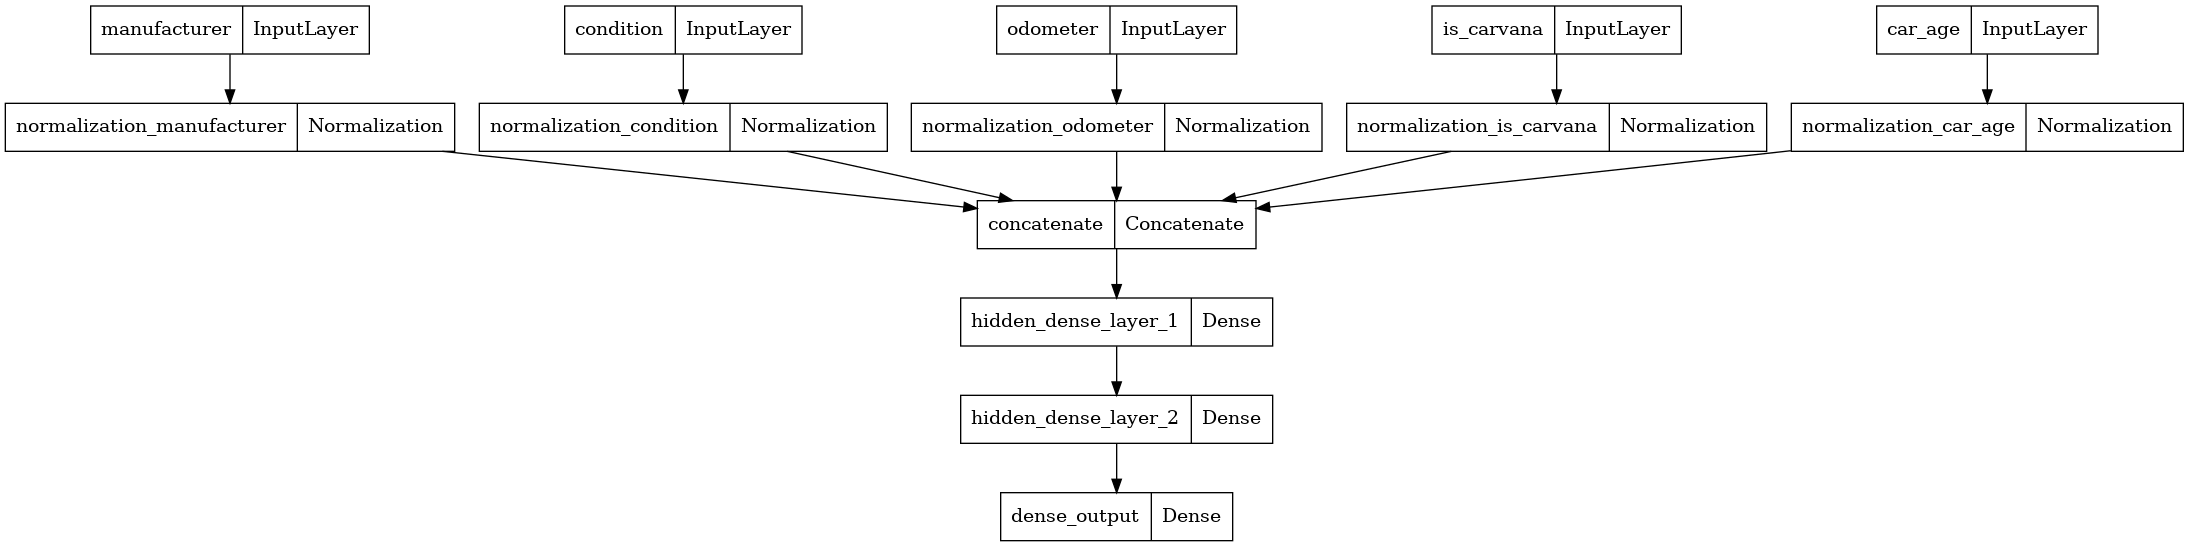

In [14]:
tf.keras.utils.plot_model(dnn_model)

Finally, let's train our model using an 80:20 train:validation split and see how it performs:

In [15]:
tf.config.run_functions_eagerly(True)

history = dnn_model.fit(
    {name:np.array(value) for name, value in X_train.items()},
    np.array(y_train.values),
    epochs=15,
    batch_size=1000,
    shuffle=True,
    validation_split=0.2
)

# Get details that will be useful for plotting the loss curve.
epochs = history.epoch
hist = pd.DataFrame(history.history)
mse = hist["mean_squared_error"]

Epoch 1/15
  6/105 [>.............................] - ETA: 1s - loss: 403991296.0000 - mean_squared_error: 403991296.0000

/home/chris/.local/lib/python3.8/site-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


105/105 [==============================] - 1s 13ms/step - loss: 358133504.0000 - mean_squared_error: 358133504.0000 - val_loss: 203384976.0000 - val_mean_squared_error: 203384976.0000
Epoch 2/15
105/105 [==============================] - 1s 13ms/step - loss: 126500992.0000 - mean_squared_error: 126500992.0000 - val_loss: 104939104.0000 - val_mean_squared_error: 104939104.0000
Epoch 3/15
105/105 [==============================] - 1s 13ms/step - loss: 106304792.0000 - mean_squared_error: 106304792.0000 - val_loss: 103480072.0000 - val_mean_squared_error: 103480072.0000
Epoch 4/15
105/105 [==============================] - 1s 13ms/step - loss: 105334984.0000 - mean_squared_error: 105334984.0000 - val_loss: 102911144.0000 - val_mean_squared_error: 102911144.0000
Epoch 5/15
105/105 [==============================] - 1s 13ms/step - loss: 104837904.0000 - mean_squared_error: 104837904.0000 - val_loss: 102508936.0000 - val_mean_squared_error: 102508936.0000
Epoch 6/15
105/105 [================

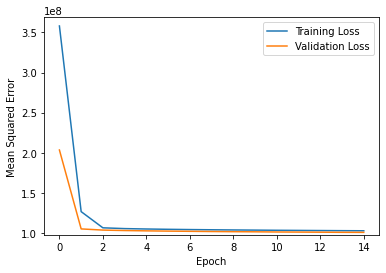

In [16]:
plt.figure()
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")

plt.plot(epochs, mse, label="Training Loss")
plt.plot(epochs, history.history["val_mean_squared_error"], label="Validation Loss")

# mse_training is a pandas Series, so convert it to a list first.
merged_mse_lists = mse.tolist() + history.history["val_mean_squared_error"]
highest_loss = max(merged_mse_lists)
lowest_loss = min(merged_mse_lists)
top_of_y_axis = highest_loss * 1.03
bottom_of_y_axis = lowest_loss * 0.97

plt.ylim([bottom_of_y_axis, top_of_y_axis])
plt.legend()
plt.show()

Looks like it converged pretty decently! If we remember how MSE is calculated, taking the square root will give us the absolute average error. In this case, $\sqrt{100618240}\approx 10000$. So our predictions aren't awesome, but are only off by an average of about $10k up or down which definitely could be worse! Some more time spent feature engineering and fine tuning the model architecture would likely get us a model that's in a much closer ballpark when predictin vehicle price.

Finally, let's see how we held up against the testing dataset:

In [19]:
print("\n Evaluate the new model against the test set:")
dnn_model.evaluate(
    x={name:np.array(value) for name, value in X_test.items()},
    y=np.array(y_test.values),
    batch_size=1000,
    return_dict=True)


 Evaluate the new model against the test set:
33/33 [==============================] - 0s 5ms/step - loss: 102548720.0000 - mean_squared_error: 102548720.0000


{'loss': 102548720.0, 'mean_squared_error': 102548720.0}